In [1]:
#pip install modin[dask]

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
os.environ["MODIN_ENGINE"] = "dask"

# Coronavirus Global Cases Predictions with Support Vector Machine (SVM)  Polynomial, Sigmoid and Radial Basis Function Regression

In [4]:
### import libraries
import modin.pandas as pd #Dataframe manipulation library
import numpy as np #Library to handle data in a vectorized manner
import matplotlib.pyplot as plt #Matplotlib and associated plotting modules
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib import style
import math #Math functions
import requests #library to handle requests
import os
import random
import time
import datetime
import warnings
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Dataset

This data is collected from repository for the 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE).https://github.com/CSSEGISandData/COVID-19

In [5]:
###Import the data from CSSE at Johns Hopkins University (https://systems.jhu.edu/)
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

To request implementation, send an email to feature_requests@modin.org.


In [6]:
###Index columns as DataFrame series
cols = confirmed_df.keys()

In [7]:
###Get all the dates for the outbreak
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [8]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
active_cases = []

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)
    total_recovered.append(recovered_sum)
    active_cases.append(confirmed_sum-(recovered_sum+death_sum))
    active_cases_sum=(confirmed_sum-(recovered_sum+death_sum)).sum()

In [9]:
###Convert integer into datetime for better visualization
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')

In [10]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)
active_cases = np.array(active_cases).reshape(-1, 1)

In [11]:
###Future forecast
days_in_future = 3
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))
adjusted_dates = future_forcast_dates[:-3]

In [12]:
warnings.filterwarnings("ignore")

In [13]:
# Train parameters to predict labels, use 10% for Test set
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.1, shuffle=False) 
X_train_recovered, X_test_recovered, y_train_recovered, y_test_recovered = train_test_split(days_since_1_22, total_recovered, test_size=0.1, shuffle=False)
X_train_deaths, X_test_deaths, y_train_deaths, y_test_deaths = train_test_split(days_since_1_22, total_deaths, test_size=0.1, shuffle=False)
X_train_active, X_test_active, y_train_active, y_test_active = train_test_split(days_since_1_22, active_cases, test_size=0.1, shuffle=False) 
X_train_mortality, X_test_mortality, y_train_mortality, y_test_mortality = train_test_split(days_since_1_22, mortality_rate , test_size=0.1, shuffle=False) 
X_train_recovery, X_test_recovery, y_train_recovery, y_test_recovery = train_test_split(days_since_1_22, recovery_rate, test_size=0.1, shuffle=False) 

In [14]:
kernel = ['sigmoid','poly','rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel': kernel, 'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

svm = SVR()

In [15]:
svm_search = RandomizedSearchCV(svm,svm_grid,scoring='neg_mean_squared_error',cv=5,return_train_score=True,n_jobs=-1,n_iter=10,verbose=1)
svm_search.fit(X_train_confirmed, y_train_confirmed.ravel())
svm_search.best_params_
svm_confirmed = svm_search.best_estimator_
svm_pred_confirmed = svm_confirmed.predict(future_forcast)

svm_search = RandomizedSearchCV(svm,svm_grid,scoring='neg_mean_squared_error',cv=5,return_train_score=True,n_jobs=-1,n_iter=10,verbose=1)
svm_search.fit(X_train_active, y_train_active.ravel())
svm_search.best_params_
svm_active = svm_search.best_estimator_
svm_pred_active = svm_active.predict(future_forcast)

svm_search = RandomizedSearchCV(svm,svm_grid,scoring='neg_mean_squared_error',cv=5,return_train_score=True,n_jobs=-1,n_iter=10,verbose=1)
svm_search.fit(X_train_recovered, y_train_recovered.ravel())
svm_search.best_params_
svm_recovered = svm_search.best_estimator_
svm_pred_recovered = svm_recovered.predict(future_forcast)

svm_search = RandomizedSearchCV(svm,svm_grid,scoring='neg_mean_squared_error',cv=5,return_train_score=True,n_jobs=-1,n_iter=10,verbose=1)
svm_search.fit(X_train_deaths, y_train_deaths.ravel())
svm_search.best_params_
svm_deaths = svm_search.best_estimator_
svm_pred_deaths = svm_deaths.predict(future_forcast)

svm_search = RandomizedSearchCV(svm,svm_grid,scoring='neg_mean_squared_error',cv=5,return_train_score=True,n_jobs=-1,n_iter=10,verbose=1)
svm_search.fit(X_train_mortality, y_train_mortality)
svm_search.best_params_
svm_mortality = svm_search.best_estimator_
svm_pred_mortality = svm_mortality.predict(future_forcast)

svm_search = RandomizedSearchCV(svm,svm_grid,scoring='neg_mean_squared_error',cv=5,return_train_score=True,n_jobs=-1,n_iter=10,verbose=1)
svm_search.fit(X_train_recovery, y_train_recovery)
svm_search.best_params_
svm_recovery = svm_search.best_estimator_
svm_pred_recovery = svm_recovery.predict(future_forcast)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 12.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 190.1min finished


In [2]:
plt.figure(figsize=(20, 12))
plt.style.use('dark_background')
plt.plot(adjusted_dates, world_cases, color='white')
plt.plot(future_forcast_dates, svm_pred_confirmed, linestyle='dotted', color='white')
plt.plot(adjusted_dates, total_recovered, color='green')
plt.plot(future_forcast_dates, svm_pred_recovered, linestyle='dotted', color='green')
plt.plot(adjusted_dates, total_deaths, color='red')
plt.plot(future_forcast_dates, svm_pred_deaths, linestyle='dotted', color='red')
plt.plot(adjusted_dates, world_cases, color='black')
plt.plot(future_forcast_dates, svm_pred_confirmed, linestyle='dotted', color='black')
plt.plot(adjusted_dates, active_cases, color='orange')
plt.plot(future_forcast_dates, svm_pred_active, linestyle='dotted', color='orange')
plt.title('Predictions of Confirmed, Recovery & Death Cases of Coronavirus', size=30)
plt.legend(['Number of Confirmed Cases', 'Confirmed Cases SVM Prediction', 'Number of Recovery Cases', 'Recovery Cases SVM Prediction', 'Number of Death Cases', 'Death Cases SVM Prediction', 'Number of Active Cases', 'Active Cases SVM Prediction','Number of Confirmed Cases',  'Confirmed Cases SVM Prediction', 'Number of Active Cases', 'Active Cases SVM Prediction'], loc='upper left', fontsize=15)
plt.xlabel('Time in Days', size=30)
plt.ylabel('Number of Cases', size=30)
plt.xticks(rotation=50, size=12)
plt.show()

NameError: name 'plt' is not defined

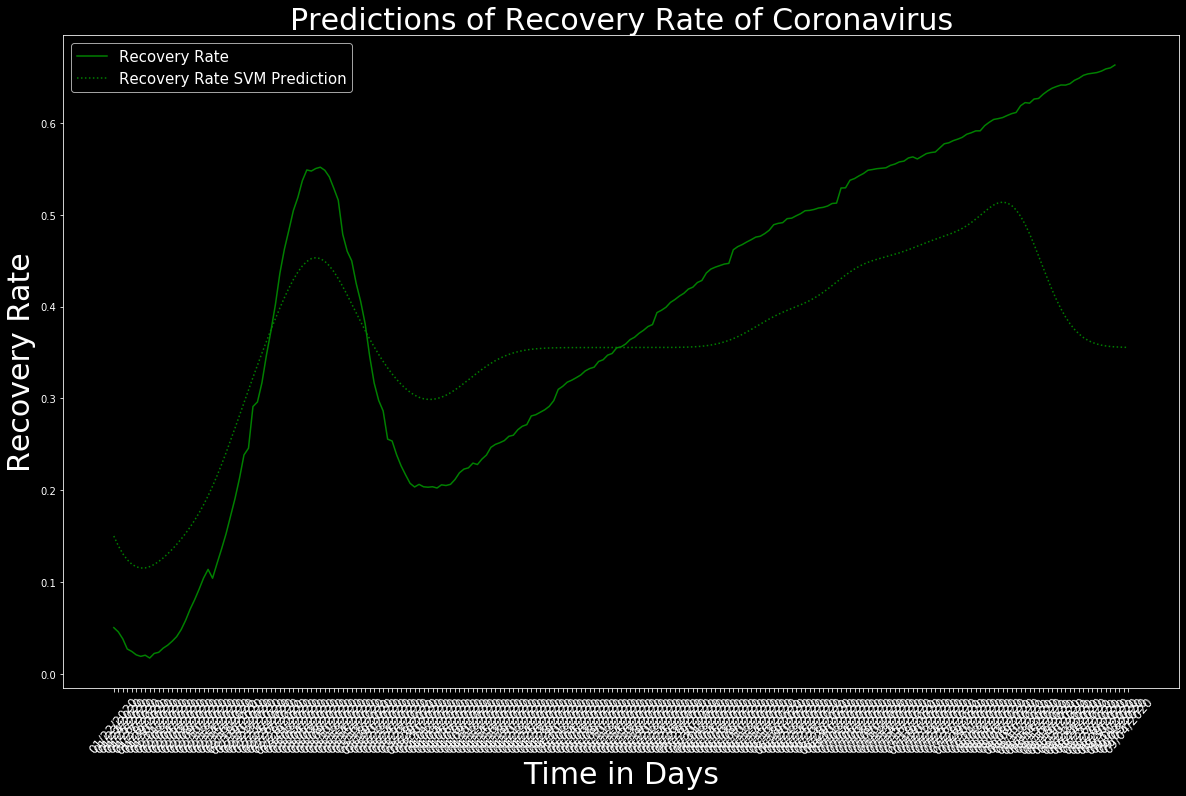

In [17]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, recovery_rate, color='green')
plt.plot(future_forcast_dates, svm_pred_recovery, linestyle='dotted', color='green')
plt.title('Predictions of Recovery Rate of Coronavirus', size=30)
plt.legend(['Recovery Rate',  'Recovery Rate SVM Prediction'], loc='upper left', fontsize=15)
plt.xlabel('Time in Days', size=30)
plt.ylabel('Recovery Rate', size=30)
plt.xticks(rotation=50, size=12)
plt.show()

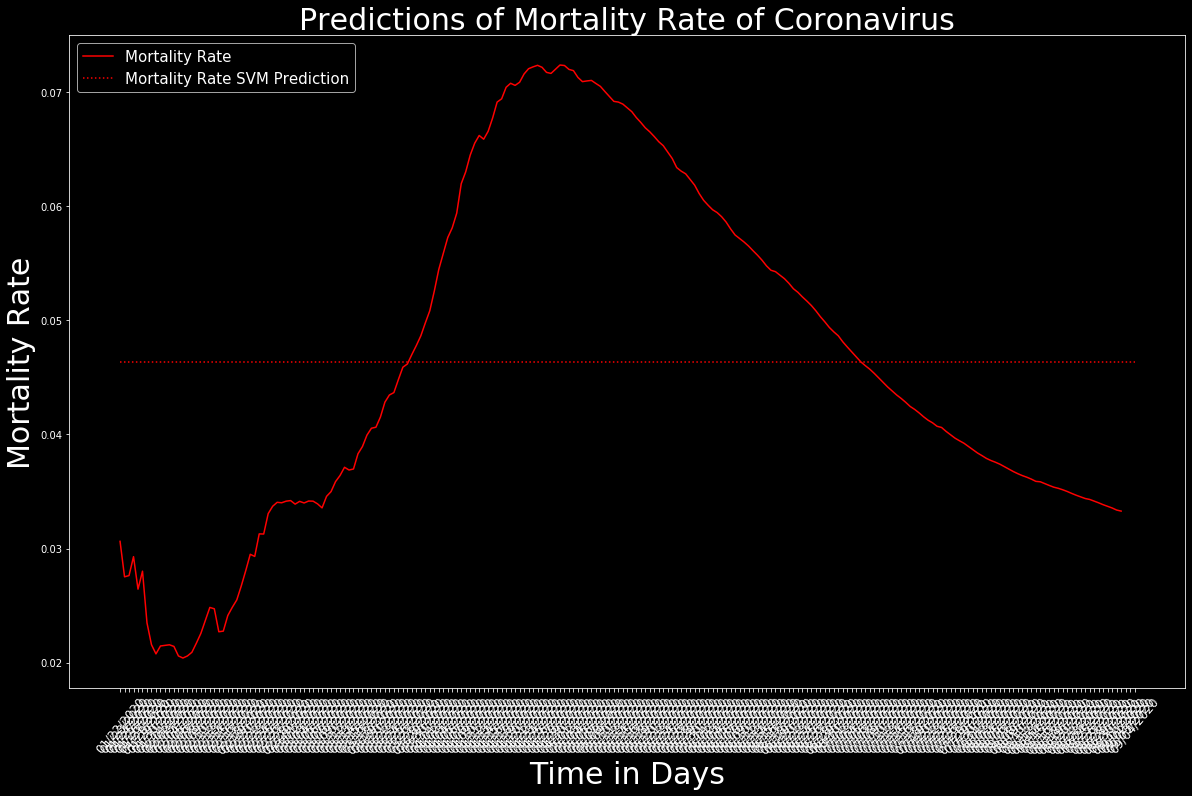

In [18]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, mortality_rate, color='red')
plt.plot(future_forcast_dates, svm_pred_mortality, linestyle='dotted', color='red')
plt.title('Predictions of Mortality Rate of Coronavirus', size=30)
plt.legend(['Mortality Rate', 'Mortality Rate SVM Prediction'], loc='upper left', fontsize=15)
plt.xlabel('Time in Days', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(rotation=50, size=12)
plt.show()